In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from sklearn.decomposition import PCA

In [3]:
# large dataset
large_X_raw = np.load('drive/MyDrive/train.npy', allow_pickle=True)
large_y = pd.read_csv('drive/MyDrive/train_labels.csv')['label'].values
scaler_large = StandardScaler()
large_X = scaler_large.fit_transform(large_X_raw).T  # shape: (features, samples)

# small dataset
df_small = pd.read_csv('drive/MyDrive/optdigits_8x8.csv')
small_X_raw = df_small.iloc[:, :-1].values
small_y = df_small.iloc[:, -1].values
scaler_small = StandardScaler()
small_X = scaler_small.fit_transform(small_X_raw).T  # shape: (features, samples)

In [4]:
def evaluate_models(X, y, dataset_name):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    models = {
        'SVM': LinearSVC(max_iter=10000),
        'DecisionTree': DecisionTreeClassifier(),
        'NeuralNetwork': 'keras'
    }

    f1_scores = {name: [] for name in models}
    durations = {name: [] for name in models}

    for train_idx, test_idx in skf.split(X.T, y):
        X_train = X[:, train_idx].T
        X_test = X[:, test_idx].T
        y_train = y[train_idx]
        y_test = y[test_idx]

        for name, model in models.items():
            start = time.time()

            if name == 'NeuralNetwork':
                y_train_cat = to_categorical(y_train, num_classes=10)
                y_test_cat = to_categorical(y_test, num_classes=10)

                model_keras = Sequential([
                    Input(shape=(X.shape[0],)),
                    Dense(32, activation='relu'),
                    Dense(10, activation='softmax')
                ])
                model_keras.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01), metrics=[])
                model_keras.fit(X_train, y_train_cat, epochs=20, batch_size=32, verbose=0)

                preds = model_keras.predict(X_test)
                preds_classes = np.argmax(preds, axis=1)
                f1 = f1_score(y_test, preds_classes, average='macro')

            else:
                model.fit(X_train, y_train)
                preds = model.predict(X_test)
                f1 = f1_score(y_test, preds, average='macro')

            end = time.time()

            f1_scores[name].append(f1)
            durations[name].append(end - start)

    mean_f1 = {name: np.mean(scores) for name, scores in f1_scores.items()}
    mean_duration = {name: np.mean(times) for name, times in durations.items()}

    return mean_f1, mean_duration

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
417/417 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


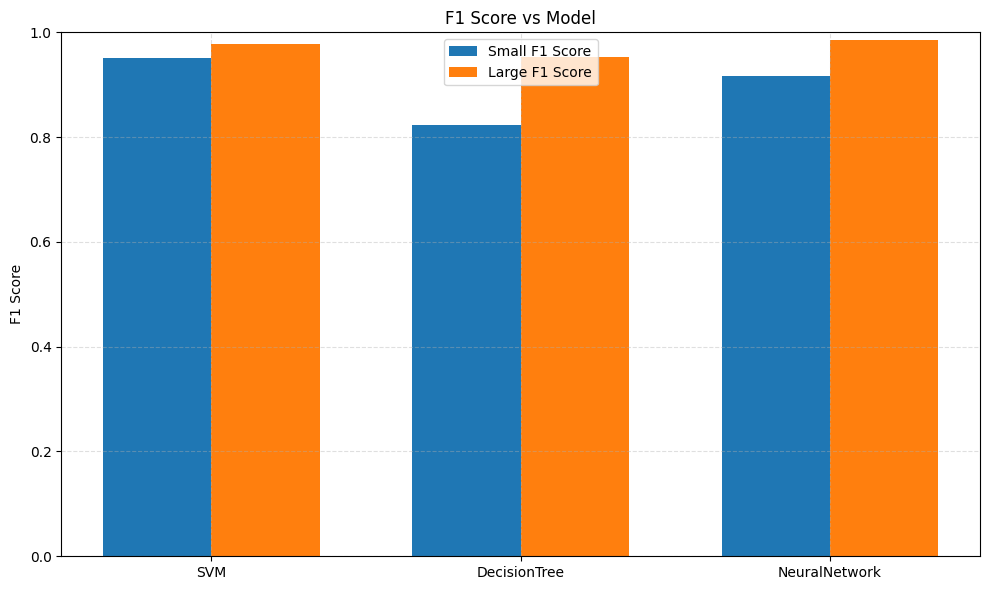

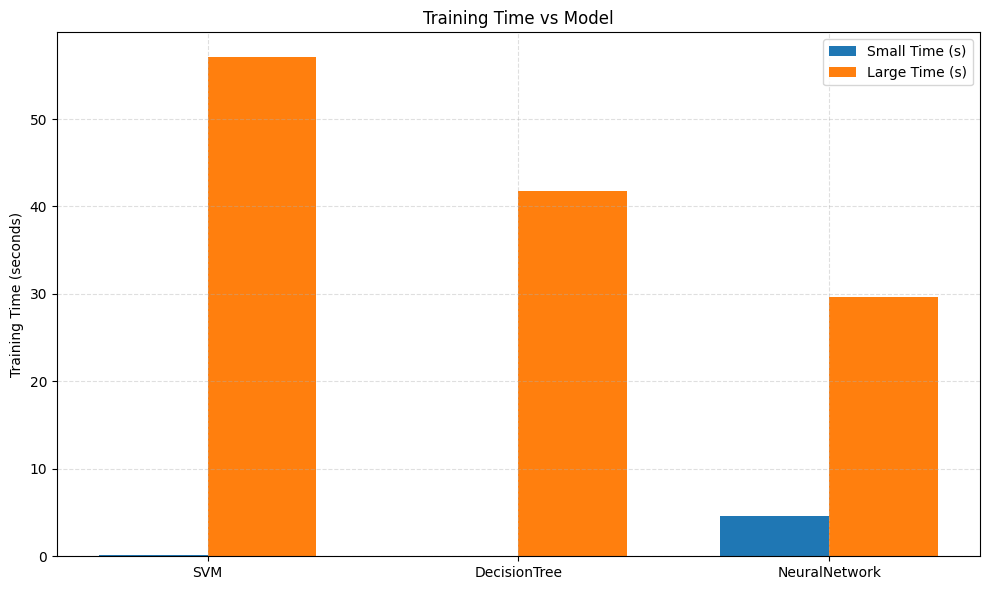

In [5]:
pca_small = PCA(n_components=0.95)
small_X_pca = pca_small.fit_transform(small_X.T).T  # (components, samples)

pca_large = PCA(n_components=0.95)
large_X_pca = pca_large.fit_transform(large_X.T).T  # (components, samples)

f1_small, time_small = evaluate_models(small_X_pca, small_y, 'Small Dataset')
f1_large, time_large = evaluate_models(large_X_pca, large_y, 'Large Dataset')

models = ['SVM', 'DecisionTree', 'NeuralNetwork']
x = np.arange(len(models))
width = 0.35

# f1 score graph
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(x - width/2, [f1_small[m] for m in models], width, label='Small F1 Score')
ax1.bar(x + width/2, [f1_large[m] for m in models], width, label='Large F1 Score')
ax1.set_ylabel('F1 Score')
ax1.set_title('F1 Score vs Model')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.set_ylim(0, 1)
ax1.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# time graph
fig, ax2 = plt.subplots(figsize=(10, 6))
ax2.bar(x - width/2, [time_small[m] for m in models], width, label='Small Time (s)')
ax2.bar(x + width/2, [time_large[m] for m in models], width, label='Large Time (s)')
ax2.set_ylabel('Training Time (seconds)')
ax2.set_title('Training Time vs Model')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [6]:
print("=== TRAINING TIME RESULTS ===")
for m in models:
    print(f"{m} - Small Dataset: {time_small[m]:.2f} seconds")
    print(f"{m} - Large Dataset: {time_large[m]:.2f} seconds")
    print("-" * 40)

=== TRAINING TIME RESULTS ===
SVM - Small Dataset: 0.17 seconds
SVM - Large Dataset: 57.06 seconds
----------------------------------------
DecisionTree - Small Dataset: 0.06 seconds
DecisionTree - Large Dataset: 41.76 seconds
----------------------------------------
NeuralNetwork - Small Dataset: 4.60 seconds
NeuralNetwork - Large Dataset: 29.66 seconds
----------------------------------------


In [7]:
print("=== F1 SCORE RESULTS ===")
for m in models:
    print(f"{m} - Small Dataset F1: {f1_small[m]:.4f}")
    print(f"{m} - Large Dataset F1: {f1_large[m]:.4f}")
    print("-" * 40)

=== F1 SCORE RESULTS ===
SVM - Small Dataset F1: 0.9506
SVM - Large Dataset F1: 0.9781
----------------------------------------
DecisionTree - Small Dataset F1: 0.8240
DecisionTree - Large Dataset F1: 0.9521
----------------------------------------
NeuralNetwork - Small Dataset F1: 0.9158
NeuralNetwork - Large Dataset F1: 0.9848
----------------------------------------
